Disable warnings, set Matplotlib inline plotting and load Pandas package.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

Load train dataset from HDFS and explore data. The dataset has the following fields. The Churn field is what we wants to predict.

In [2]:
train_data = sqlContext.read.load('./dataset/churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

train_data.cache()
train_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



Explore the first five rows.

In [3]:
pd.DataFrame(train_data.take(5), columns=train_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Show summary statistics of all fields.

In [4]:
train_data.describe().toPandas()

,summary,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,None,100.62040510127532,437.43885971492875,None,None,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413
2,stddev,None,39.56397365334985,42.521018019427174,None,None,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093
3,min,AK,1,408,No,No,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0
4,max,WY,243,510,Yes,Yes,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9


Count churn customers.

In [5]:
train_data.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
| true|  388|
|false| 2278|
+-----+-----+



Convert categorical fields into numeric fields.

In [6]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

#labelIndexer = StringIndexer(inputCol = 'Churn', outputCol = 'label')
ipIndexer = StringIndexer(inputCol = 'International plan', outputCol = 'ipIndex')
ipEncoder = OneHotEncoder(inputCol = 'ipIndex', outputCol = 'ipVector')

Define feature fields. We choose to ignore some fields as we think they are not relevant.

In [7]:
from pyspark.ml.feature import VectorAssembler

featureCols = ['Account length', 'ipVector', 'Number vmail messages', 'Total day minutes',
     'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 
     'Total intl minutes', 'Total intl calls', 'Customer service calls']
assembler = VectorAssembler(inputCols = featureCols, outputCol = 'features')

Create a logistic transformer.

In [8]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter = 20)

Create numeric label field.

In [9]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

toNum = udf(lambda v: float(v), DoubleType())
train_data = train_data.withColumn('label', toNum(train_data['Churn'])).cache()
pd.DataFrame(train_data.take(5), columns=train_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,label
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,0.0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,False,0.0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,False,0.0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,False,0.0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,False,0.0


Chain all transformers and train the model.

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[ipIndexer, ipEncoder, assembler, lr])
model = pipeline.fit(train_data)

Display auROC of the trained model.

In [11]:
lrModel = model.stages[-1]
trainingSummary = lrModel.summary
print ('Train auROC = %3.2f' % trainingSummary.areaUnderROC)

Train auROC = 0.81


Plot ROC Curve.

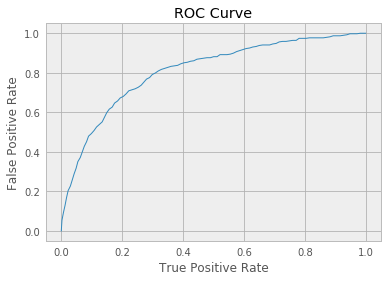

In [12]:
import matplotlib.pyplot as plt

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Load test dataset from HDFS and evaluate the model with test data.

In [13]:
test_data = sqlContext.read.load('./dataset/churn-bigml-20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

test_data.cache()
test_data = test_data.withColumn('label', toNum(test_data['Churn'])).cache()

predictions = model.transform(test_data)


Evaluate the auROC of the test data.

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction')
auROC = evaluator.evaluate(predictions)
print("Test auROC = %3.2f" % auROC)

Test auROC = 0.80


Evaluate the accuracy of the test data.

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName="accuracy")
accuracy = multi.evaluate(predictions)
print("Accuracy = %3.2f" % accuracy)

Accuracy = 0.85
